<a href="https://colab.research.google.com/github/vchandraiitk/datascience/blob/main/M1_MP2_NB_Hypothesis_Testing_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook 2: Hypothesis Testing

## Learning Objectives



At the end of this Mini Project, you will be able to :


* Have a very surface and high-level level understanding of A/B Testing - a statistical way to compare two or more versions (A or B?)

* Determine not only which one (A or B) performs better but also to understand if the difference between two of them is statistically significant

* Derive meaningful insights from the formula for Confidence Intervals with the t-distribution and how to adjust this formula using the Central Limit Theorem

* Know the dependant 3 factors (Power of the test, Significance level & Minimal Desired Effect) for having a required Sample Size

* Carry out Binomial Proportion Confidence Intervals, 2-sample Z-test, Hypothesis testing on difference & Effect Size & Chi-square test. The objective of this mini project is to serve as an introductory guide to A/B testing, covering foundational concepts and methodologies.


## Introduction

A/B tests are very commonly performed by data analysts and data scientists. It is important to get some practice working with these difficulties.

A/B testing is a crucial technique in data-driven decision-making, yet it often lacks comprehensive exploration. This notebook aims to address this gap by providing a consolidated overview of A/B testing principles and practices.

For this mini project, you will be working to understand the results of an A/B test run by an e-commerce website. Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

## Dataset

The dataset chosen for this experiment is the **ab_data.csv** dataset which is publicly available on [Kaggle](https://www.kaggle.com/datasets/abdelrahmanrezk7/ab-testing-e-commerce-website)  

This dataset consists of 2,94,478 records. Each record is made up of 5 fields.

**For example**, Each record consists of 'user_id', 'timestamp', 'group', 'landing_page' and 'converted'.

* **user_id:** A unique identifier assigned to each user participating in the experiment.

* **timestamp:** The timestamp indicating the time at which the user interacted with the webpage or was exposed to the experimental condition.

* **group:** The group to which the user was assigned, typically denoted as either 'control' or 'treatment'. This field helps categorize users into different experimental conditions.

* **landing_page:** Specifies the type of landing page or webpage variant that the user was directed to upon interaction. It distinguishes between different versions of the webpage used in the experiment.

* **converted:** A binary indicator representing whether the user performed the desired action or conversion after interacting with the webpage. It typically indicates whether the user made a purchase, signed up for a service, or completed any other desired action.

## Problem Statement

The biggest e-commerce company called FaceZonGoogAppFlix approached to a data science consulting firm as a new client!

They have a potential new webpage designed with the intention to increase their current conversion rates of 12% by 0.35% or more. With such an ambiguous task, they have full trust in the data science consulting firm to give them a recommendation whether to implement the new pagewebpage or keep the old webpage. Unforunately they haven't built up a data science capability in their company, but they've used an external software called 'A/B Tester' for 23 days and then come back to the data science consulting firm with a dataset. Under this requirement scenario, what the data science consulting firm will do?

## Grading = 10 Points

In [72]:
# @title Download the Dataset
! wget -q https://cdn.exec.talentsprint.com/static/cds/content/ab_data.csv
print("The datset was downloaded")

The datset was downloaded


# **Part I - Probability**

#### Import required packages

In [73]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import math as mt
import itertools
import random
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure that each of your mini project peer group members gets the same answers
np.random.seed(42)

#### Load the dataset

In [74]:
# a. Read in the dataset and take a look at the top few rows here:
# YOUR CODE HERE
df = pd.read_csv('https://cdn.exec.talentsprint.com/static/cds/content/ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [75]:
# b. Use the below cell to find the number of rows in the dataset.
# YOUR CODE HERE
df.shape[0]

294478

## Pre-processing

### Task 1: Data Cleaning

* Check the number of unique users in the dataset

* Check the proportion of users converted.
  
    **Hint:** query(), count()
* Estimate how many times the new_page and treatment don't line up. Also estimate how many times the old_page and control do not match.

* Display the total no. of non-line up pages

* Check if any of the rows have missing values?

#### **Treatment Group & Control Group**
* **Treatment Group (New Webpage):**
Users in this group will be exposed to the new webpage design.
The effectiveness of the new webpage design will be measured by comparing the conversion rates of users (who actually make purchase of the company's products after visiting this new webpage) in this group to those in the control groups.
* **Control Group 1 (Placebo):**
Users in this group will be presented with an identical-looking webpage that serves as a placebo.
This group represents the baseline scenario where users are exposed to the current webpage design without any changes.
It means that in Control Group 1, users will see a webpage that looks exactly like the current one (new one) but doesn't have any actual changes. This group helps us understand how users typically behave on the current webpage without any alterations. It's like giving users a fake version of the webpage to see how they respond, so we can compare their behavior to those users who see the real changes in the actual new webpage.
* **Control Group 2 (Old Webpage or Existing Treatment):**
Users in this group will be shown a webpage that is already in use and has demonstrated effectiveness in terms of conversion rates. It means that users in Control Group 2 will see the same old webpage that is currently being used. This webpage has been proven to be effective in terms of converting visitors into purchasers (or customers) in the past.

-- This group serves as a benchmark to evaluate whether the new webpage design outperforms the existing treatment.

-- This group (Control Group 2) acts as a standard for comparison to see if the new webpage design performs better than the current one. We will use the conversion rates observed in Control Group 2 to assess whether the changes made in the new webpage design lead to better results or not.

In [76]:
# c. The number of unique users in the dataset.
# YOUR CODE HERE
df.user_id.nunique()

290584

In [77]:
#Check the proportion of users converted.
df.query('converted == 1')['converted'].count() / df.shape[0]

0.11965919355605512

In [78]:
# identify treatment does not match with new_page
# YOUR CODE HERE
df_treatment = df.query("group=='treatment' and landing_page!='new_page'")
df_treatment.shape[0]

1965

In [79]:
# identify control does not match with old_page
# YOUR CODE HERE
df_control = df.query("group=='control' and landing_page!='old_page'")
df_control.shape[0]

1928

In [80]:
# Total no. of non-line up
# YOUR CODE HERE
#df_treatment.shape[0]+df_control.shape[0]
#df.query("group=='control' and landing_page!='old_page'").add(df.query("group=='treatment'").query("landing_page!='new_page'")).shape[0]
df.query("(group=='control' and landing_page!='old_page') or (group=='treatment' and landing_page!='new_page')").shape[0]


3893

In [81]:
# Check for any missing values
# YOUR CODE HERE
#user_id	timestamp	group	landing_page	converted
#df.isna().any()
df.isna().values.any()

False

In [82]:
# Check datatype of each column
# YOUR CODE HERE
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

### Task 2: Identify the not aligned rows

<u>**Part-2a:**</u>

With the above dataset (achieved in Task-1) the requirement is to first identify the rows in that dataset where the treatment group is aligned with the new_page and where the control group is aligned with the old_page.

**Hint:** It creates a new DataFrame containing these filtered rows.
**('group == "treatment" and landing_page == "new_page"')**

<u>**Part-2b:**</u>

Now, with the help of the new dataset (achieved in Task-2), we need to identify the misaligned rows in the dataset (achieved in Task-1) where treatment is not aligned with new_page or control is not aligned with old_page

This can be done by checking the values 'treatment' and 'control' under the 'group' column to ensure they do not correspond with the values 'new_page' and 'old_page' under the 'landing_page' column, respectively.

For the rows where treatment is not aligned with new_page or control is not aligned with old_page, we cannot be sure if this row truly received the new or old page. Write your code to provide how we should handle these rows.

In [83]:
# Part-2a
# create a new dataset that meets the specifications:
# treatment is aligned with new_page or control is aligned with old_page
#df.query("group=='treatment' and landing_page=='new_page'").shape
# YOUR CODE HERE
#df_filtered = df.query("group=='control' and landing_page!='old_page' or group=='treatment' and landing_page!='new_page'")
df_filtered = df.query("(group=='control' and landing_page=='old_page') or (group=='treatment' and landing_page=='new_page')")
df_filtered.shape

(290585, 5)

In [84]:
# show the dimension of the new dataset created
# YOUR CODE HERE
df_filtered.shape

(290585, 5)

In [85]:
# Part-2b
# Now, with the help of the new dataset (achieved above), identify the misaligned rows in the dataset (achieved in Task-1)
# where treatment is not aligned with new_page or control is not aligned with old_page
# YOUR CODE HERE
merged_df = df.merge(df_filtered, on=list(df.columns), how='left', indicator=True)
merged_df
result_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
result_df.shape

(3893, 5)

In [86]:
misaligned_df = df[~df.index.isin(df_filtered.index)]
misaligned_df.shape

(3893, 5)

In [87]:
# Double Check all of the correct rows were removed - this should be 0
# YOUR CODE HERE
df_filtered.query("group=='control' and landing_page!='old_page' or group=='treatment' and landing_page!='new_page'").shape[0]

0

### Task-3:Using the above new dataset, answer the following questions.

* How many unique user_ids are in the new dataset created above in Task-2?

* There is one user_id repeated in this dataset. What is it? (Here you need to show only the user_id)

* What is the row information for the repeat user_id? (Here, you need to show the complete row including 'user_id', 'timestamp', 'group', 'landing_page' and	'converted')

* Remove one of the rows with a duplicate user_id, but keep your dataframe name as same.

In [88]:
# YOUR CODE HERE
df_filtered['user_id'].nunique()

290584

In [89]:
# print the duplicated user_id
# drop the duplicate user_id, keep your dataframe name as same.
duplicate_user_id=df_filtered[df_filtered.duplicated('user_id', keep=False)]['user_id'].unique()
print(duplicate_user_id)

[773192]


In [90]:
# show the row information of the duplicate user_id

df_filtered[df_filtered['user_id'].isin(duplicate_user_id)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [91]:
# drop the duplicate user_id, keep your dataframe name as same.
df_filtered=df_filtered.drop_duplicates(subset='user_id')

In [92]:
df_filtered.shape[0]

290584

## Finding Probabilities

### Task 4: After removing the duplicated user_id, answer the following:

##### Exercise 1: What is the probability of an individual converting regardless of the page they receive?

In [93]:
# YOUR CODE HERE
#df_filtered['converted'].sum()/df_filtered.shape[0]
round(df_filtered['converted'].sum()/df_filtered.shape[0], 4)

0.1196

##### Exercise 2: Given that an individual was in the control group, what is the probability they converted?

In [94]:
# YOUR CODE HERE
#df_filtered.query('group == "control"').shape[0]/df_filtered.shape[0]
#df_filtered.query('group == "control" and "converted"==1')/df_filtered.query('group == "control"')
control_convert = df_filtered.query('group == "control" and converted == 1').shape[0]/df_filtered.query('group == "control"').shape[0]
#control_convert
probability_converted_control=round(control_convert, 4)
probability_converted_control

0.1204

##### Exercise 3: Given that an individual was in the treatment group, what is the probability they converted?

In [95]:
# YOUR CODE HERE
treatment_convert = df_filtered.query('group == "treatment" and converted == 1').shape[0]/df_filtered.query('group == "treatment"').shape[0]
#treatment_convert
probability_converted_treatment=round(treatment_convert, 4)
probability_converted_treatment

0.1188


##### Exercise 4: What is the probability that an individual received the new page?

In [96]:
# YOUR CODE HERE
#df_filtered.query('group == "control"').shape[0]/df_filtered.shape[0]
round(df_filtered.query('landing_page=="new_page"').shape[0]/df_filtered.shape[0], 4)


0.5001

In [97]:
# What is the probability that an individual received the old page?
# YOUR CODE HERE
#df_filtered.query("landing_page!='old_page'").shape[0]/df_filtered.shape[0]
round(df_filtered.query("landing_page=='old_page'").shape[0]/df_filtered.shape[0], 4)

0.4999

In [98]:
# show the difference: (treatment_convert - control_convert)
# YOUR CODE HERE
#treatment_convert - control_convert
diff = df_filtered.query('group == "treatment" and converted == 1').shape[0]-df_filtered.query('group == "control" and converted == 1').shape[0]
print("difference in df:",diff)
##difference in probability
diff=probability_converted_treatment - probability_converted_control
print("difference in probability df:",diff)

difference in df: -225
difference in probability df: -0.0015999999999999903


##### Exercise 5: Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions? Write your response below.

#### **Write your response here:** This difference indicates that the conversion rate in the treatment group is slightly lower than in the control group by 0.15 percentage




# **Part II - A/B Test**

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do you run to render a decision that neither page is better than another?

These questions are the difficult parts associated with A/B tests in general.

1. For now, consider you need to make the decision just based on all the data provided. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5% (i.e. 0.05), what should your null and alternative hypotheses be? You can state your hypothesis in terms of words or in terms of $p_{old}$ and $p_{new}$, which are the converted rates for the old and new pages.

$$  H_{null} : p_{new} - p_{old} <= 0 $$  

$$  H_{alternative} : p_{new} - p_{old} > 0 $$

2. Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the converted success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the converted rate in ab_data.csv regardless of the page.

Use a sample size for each page equal to the ones in ab_data.csv.

Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.

<Axes: >

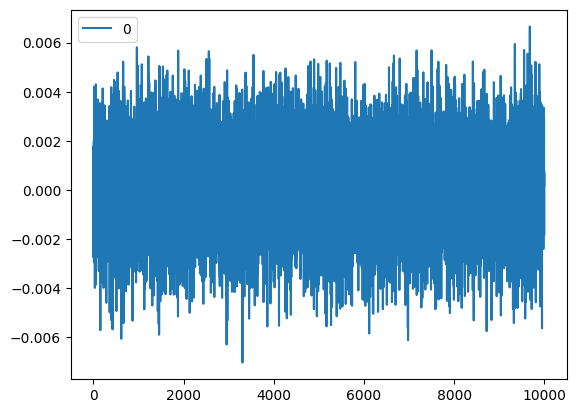

In [99]:
# YOUR CODE HERE
#overall_conversion = df_filtered.query('converted == 1').shape[0]/df_filtered.shape[0]
sampling_array=[]
treatment_size = df_filtered.query('group == "treatment"').shape[0]
control_size = df_filtered.query('group == "control"').shape[0]
for i in range (0, 10000):
    treatment = np.random.choice([0,1], treatment_size).sum()/treatment_size
    control = np.random.choice([0,1], control_size).sum()/control_size
    sampling_array.append(treatment-control)
sampling_df = pd.DataFrame(sampling_array)
sampling_df.plot()

In [100]:
df_filtered.sample(1)

,user_id,timestamp,group,landing_page,converted
280901,721082,2017-01-06 16:49:10.405955,treatment,new_page,0


### Task 5: Derive the below insights

* **$n_{old}$** - The number of individuals (each having unique user_id) who received the old page (control group)

* **$n_{new}$** - The Number of individuals (each having unique user_id) who received the new page (treatment group)

* **$p_{new}$ under the null:** This refers to the conversion rate for the new page (treatment group) that we would expect to observe if the null hypothesis ($H_{null}$) is true.
In other words, it represents the probability of conversion for users who are exposed to the new page under the assumption that there is no difference in conversion rates between the old and new pages.

So, basically **$p_{new}$ under the null** is the conversion rate for the new page that we would expect to see if the new page had no impact on user behavior compared to the old page. It serves as a reference point for evaluating the observed conversion rate for the new page in relation to the null hypothesis ($H_{null}$).

* **$p_{old}$ under the null:** This refers to the conversion rate for the old page (control group) that we would expect to observe if the null hypothesis ($H_{null}$) is true.
In other words, it represents the probability of conversion for users who are exposed to the old page under the assumption that there is no difference in conversion rates between the old and new pages.

So, basically **$p_{old}$ under the null** is the conversion rate for the old page that we would expect to see if the old page had no impact on user behavior compared to the new page. It serves as a reference point for evaluating the observed conversion rate for the old page in relation to the null hypothesis ($H_{null}$).

##### Exercise 1: What is the convert rate for $p_{new}$ under the null?

In [101]:
# YOUR CODE HERE
p_new = df_filtered.query("landing_page == 'new_page' and converted == 1")['converted'].value_counts()/df_filtered.query("landing_page == 'new_page'").shape[0]
p_old = df_filtered.query("landing_page == 'old_page' and converted == 1")['converted'].value_counts()/df_filtered.query("landing_page == 'old_page'").shape[0]
#print(p_new)
#print(p_old)
pdiff = p_new-p_old
print(pdiff)
#df_filtered.query('converted==1').shape[0]/df_filtered.shape[0]
#𝑝 under the null
p = df_filtered.query('converted==1').shape[0]/df_filtered.shape[0]
#Under the null 𝑝𝑛𝑒𝑤 = 𝑝
p_new = p
##------Final Answer
round(p_new, 4)

converted
1   -0.001578
Name: count, dtype: float64


0.1196

##### Exercise 2: What is the convert rate for $p_{old}$ under the null?



In [102]:
# YOUR CODE HERE
#Under the null 𝑝𝑜𝑙𝑑 = 𝑝
p_old = p
round(p_old, 4)

0.1196

##### Exercise 3: What is $n_{new}$?

In [103]:
# YOUR CODE HERE
n_new = df_filtered.query('group == "treatment" and landing_page == "new_page"').shape[0]
n_new

145310

##### Exercise 4: What is $n_{old}$?

In [104]:
# YOUR CODE HERE
n_old = df_filtered.query('group == "control" and landing_page == "old_page"').shape[0]
n_old

145274

this one was tricky. But here we are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same.

##### Exercise 5: Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null. Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [105]:
# YOUR CODE HERE
new_page_converted = []

for i in range (0, n_new):
    num = np.random.random()
    if num < p_new:
        new_page_converted.append(0)
    else:
        new_page_converted.append(1)
#sum(new_page_converted)/len(new_page_converted)
#new_page_converted

##### Exercise 6: Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null. Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [106]:
# YOUR CODE HERE
old_page_converted = []
for i in range (0, n_old):
    num = np.random.random()
    if num < p_old:
        old_page_converted.append(0)
    else:
        old_page_converted.append(1)

##### Exercise 7: Find $(p_{new} - p_{old})$ for your simulated values from Exercise 5 and Exercise 6.

In [107]:
# YOUR CODE HERE
diff = sum(new_page_converted)/len(new_page_converted) - sum(old_page_converted)/len(old_page_converted)
round(diff, 6)

-0.001113

##### Exercise 8: Simulate 10,000 $(p_{new}-p_{old})$ values using this same process similarly to the one you calculated in Exercise 1 through Exercise 7 above. Store all 10,000 values in $p_{diffs}$.

In [108]:
# YOUR CODE HERE
p_diffs=[]
treatment_len = df_filtered.query('group == "treatment"').shape[0]
control_len = df_filtered.query('group == "control"').shape[0]
for i in range (0, 10000):
    p_sim_new = np.random.choice([0,1], treatment_len).sum()/treatment_len
    p_sim_old = np.random.choice([0,1], control_len).sum()/control_len
    p_diffs.append(p_sim_new-p_sim_old)
#p_diffs

<Axes: >

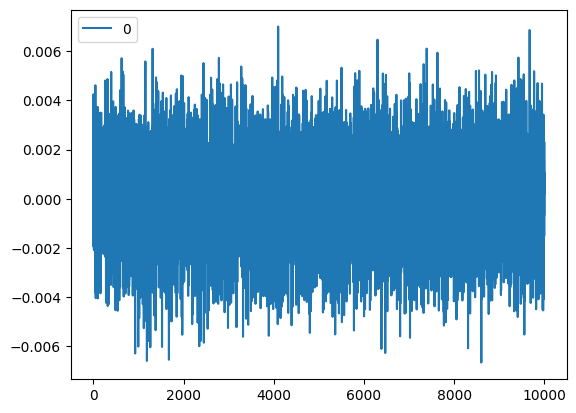

In [109]:
pd.DataFrame(p_diffs).plot()

Alternatively, we can do the same approach using the following snippet in order to eliminate the use of for:

<Axes: >

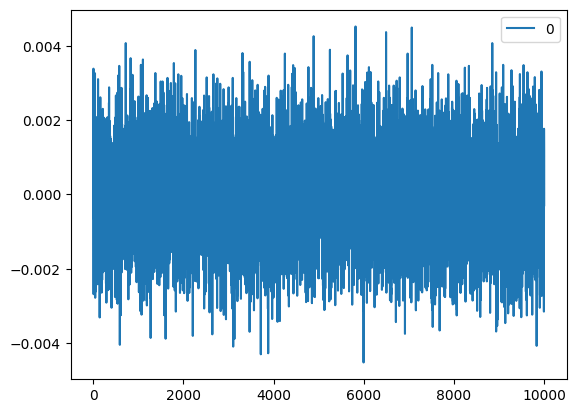

In [110]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
l = new_converted_simulation - old_converted_simulation
pd.DataFrame(l).plot()
# Essentially, we are applying the null proportion to the total size of each page using the binomial distribution.
# Each element, for example, innp.random.binomial(n_new, p_new, 10000) results in an array with values like [17262, 17250, 17277...].
# This array is 10000 elements large When we divide it by n_new, Python broadcasts n_new for each element and we return a proportion for each element.
# This is essentially is simulating, 10000, the new page conversion rate.

##### Exercise 9: Plot a histogram of the $p_{diffs}$. Does this plot look like what you expected? Use the matching problem to assure your understanding on what was computed here.

'100.0%'

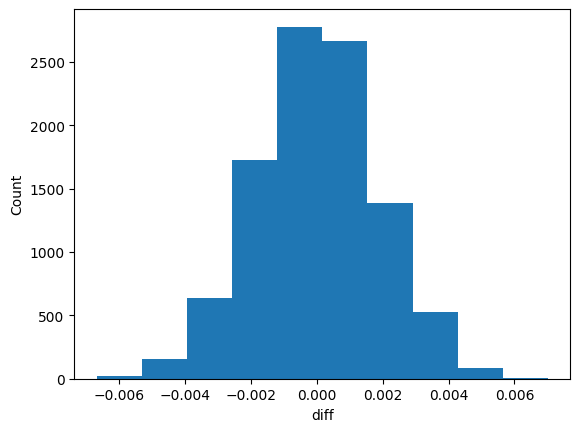

In [111]:
# YOUR CODE HERE
plt.hist(p_diffs)
plt.xlabel('diff')
plt.ylabel('Count')
counter=0
for i in p_diffs:
    if i <= 0.05:
        counter += 1
str((counter/len(p_diffs)*100))+'%'

In [112]:
# save p_diffs for later use
# YOUR CODE HERE
pd.DataFrame(p_diffs).to_csv('/content/p_diffs.csv', index=False)
len(p_diffs)

10000

The sample size of df2 is large enough that our sampling distribution is bell shaped. As we observed the actual difference in $(p_{new}-p_{old})$, based on the confidence interval, we have an equal difference in means between old and new pages. The normal distribution is small, that is, it's between (-0.05 and +0.05).

##### Exercise 10: What proportion of the $p_{diffs}$ are greater than the actual difference observed in ab_data.csv?

In [113]:
# YOUR CODE HERE
total = 0
#print(pdiff.item())
#type((p_new-p_old))
for i in p_diffs:
    if i > pdiff.item():
        total += 1
total*100/len(p_diffs)

80.87

##### Exercise 11: In words, explain what you just computed in Exercise 10.
What is this value called in scientific studies?

What does this value mean in terms of whether or not there is a difference between the new and old pages?

Text(0, 0.5, 'Count')

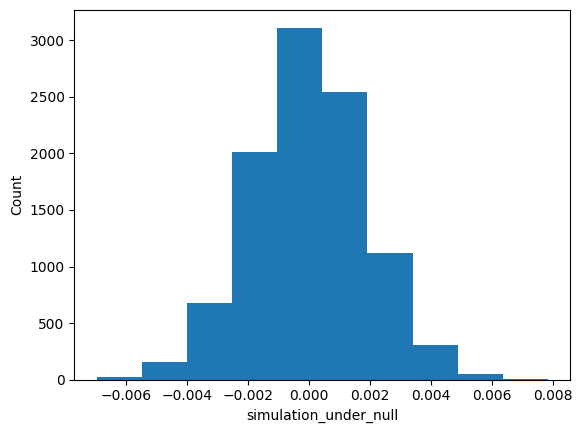

In [114]:
# What is this value called in scientific studies?
#Answer-1 -> p-value
#Answer-2 -> 100% p-value are less than 0.05 so null Hypothesis is true.
# Simulate distribution under the null hypothesis
# YOUR CODE HERE
mu_0 = 0 #under null hypothesis mean is 0
simulation_under_null = np.random.normal(mu_0, np.std(p_diffs), len(p_diffs))
# Plot the null distribution
# YOUR CODE HERE
plt.hist(simulation_under_null)
plt.xlabel('simulation_under_null')
plt.ylabel('Count')

In [115]:
# Compute p-value (consider h_alternative : p_new > p_old)
# YOUR CODE HERE
# n_new = 1000
# n_old = 1000
# treatment_size = 550
# control_size = 500

convert_new_nu = df_filtered.query("landing_page == 'new_page' and converted == 1").shape[0]
convert_old_nu = df_filtered.query("landing_page == 'old_page' and converted == 1").shape[0]

# Sample proportions
p_new1 = convert_new_nu / n_new
p_old1 = convert_old_nu / n_old
print(treatment_size)
print(control_size)
print(convert_new_nu)
print(convert_old_nu)
# Combined proportion
p_combined1 = (convert_new_nu+convert_old_nu)/(treatment_size + control_size)

# Standard error
SE = np.sqrt(p_combined1 * (1 - p_combined1) * (1/n_new + 1/n_old))
print(p_combined1)
# Test statistic
z = (p_new1 - p_old1) / SE

# P-value for one-tailed test
p_value1 = 1 - ss.norm.cdf(z)

print(f'p_new: {p_new1}')
print(f'p_old: {p_old1}')
print(f'Combined proportion: {p_combined1}')
print(f'Standard error: {SE}')
print(f'Test statistic (z): {z}')
print(f'p-value: {p_value1}')

145310
145274
17264
17489
0.11959708724499628
p_new: 0.11880806551510564
p_old: 0.1203863045004612
Combined proportion: 0.11959708724499628
Standard error: 0.0012039132295014454
Test statistic (z): -1.3109241984234394
p-value: 0.9050583127590245


**The actual difference is captured in the population. Since $p_{value}>0.05$, we would fail to reject the null hypothesis.**

100% of values from our null distribution fall to the right our actual difference. The old page has a higher probability of convertion rate than the new page.

##### Exercise 12: We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

Write your code in the below cells to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let $n_{old}$ and $n_{new}$ refer the the number of rows associated with the old page and new pages, respectively.

In [116]:
# the number of conversions for each page
# YOUR CODE HERE
convert_old = df_filtered.query('group == "control" & converted == 1').shape[0]
convert_new = df_filtered.query('group == "treatment" & converted == 1').shape[0]
# the number of individuals who received each page
# YOUR CODE HERE
num_old = df_filtered.shape[0] - df_filtered.query('group == "control"').shape[0]
num_new = df_filtered.query('group == "treatment"').shape[0]

##### Exercise 13: Now use stats.proportions_ztest to compute your test statistic and p-value. Here is a helpful [link](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) on using the built in.

In [117]:
# YOUR CODE HERE
from statsmodels.stats.proportion import proportions_ztest
count = np.array([convert_old, convert_new])
nobs = np.array([num_old, num_new])
stat, pval = proportions_ztest(count, nobs)

In [118]:
# print the z_score and p_value
# YOUR CODE HERE
print(f"z-score '{round(stat,4)}'")
print(f"p-value '{round(pval,4)}'")

z-score '1.2863'
p-value '0.1983'


In [119]:
from scipy.stats import norm
# Tells us how significant our z-score is?
# YOUR CODE HERE
significance_level = 0.05
if pval < significance_level:
    print("The result is statistically significant.")
else:
    print("The result is not statistically significant.")

The result is not statistically significant.


In [120]:
# Tells us what our critical value at 95% confidence is?
# YOUR CODE HERE
confidence_level = 0.95
alpha = 1 - confidence_level

# For a two-tailed test (which is typical for confidence intervals), divide alpha by 2
alpha /= 2

# Calculate the critical value
critical_value = norm.ppf(1 - alpha)

print("Critical value at 95% confidence:", critical_value)

Critical value at 95% confidence: 1.959963984540054


##### Exercise 14: What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages? Do they agree with the findings in parts Exercise 10 and Exercise 11?

#### **Your response here:**

**We would view various methods to conclude if $p_{new} = p_{old}$ or $p_{new} > p_{old}$:**

**Method-1: Binomial Proportion Confidence Intervals**

This method is quoted as the 'most common' method for A/B testing, where we find Confidence Intervals (CI) for both $p_{new}$ and $p_{old}$. If we construct similar intervals for both and compare them, we will end up in either scenario:

1. The Intervals do not overlap: This implies that we can say with some level of confidence that one is better than the other, therefore providing enough evidence to reject the Null Hypothesis. This level of confidence seems to be $≈ 1-e \alpha^{1.91}%$ (Lan, 2011). So if there is overlap and the 95% CI are the same size, the difference is significant at the 99.5% level.

2. The Intervals do overlap: Then it is either a sign that our population does not have enough statistical power, or we do not have enough evidence to reject the Null Hypothesis that $p_{new} = p_{old}$.

There is a relationship between CI comparisons and hypothesis tests - given that the sample sizes are not too different and the two sets have similar standard deviations.

Finding the 'true' conversion rate of a particular group is usually impossible or difficult, but we can use our calculated $p_{new}$ and $p_{old}$ as point estimations to find the Confidence Intervals for the 'true' $p_{new}$ and $p_{old}$.

In this context we define $CI_{new}$ and $CI_{old}$ as below.
* **$CI_{new}$:** The confidence interval $CI_{new}$ represents the range of values within which we estimate the true conversion rate $p_{new}$ of the new group lies with 95% confidence.

* **$CI_{old}$:** The confidence interval $CI_{old}$ represents the range of values within which we estimate the true conversion rate $p_{old}$ of the old group lies with 95% confidence.

Exercise 1: Define a customized function **get_z_score()** to get the z-score. Consider $\alpha = 5$%

**Hint:** You can use the inverse cumulative distribution function (CDF) of the standard normal distribution [i.e., scipy.stats.norm.ppf() in Python] to find the z-score

In [121]:
#function for getting z-scores for alpha. For our experiemnt where alpha = 5%, keep in mind we want to input 1-alpha/2 for Confidence Intervals.
# YOUR CODE HERE
def get_z_score(alpha):
    return norm.ppf(1 - alpha / 2)

# Example usage
alpha = 0.05
z_score = get_z_score(alpha)
z_score

1.959963984540054

Exercise 2 **(Optional)**: Now calculate the $CI_{old}$ and $CI_{new}$ using the **get_z_score** and given $\alpha = 5$%

In [122]:
# check whether Confidence Interval old (CI_old) & Confidence Interval new (CI_new) overlap?
# YOUR CODE HERE
#ci_old = (treatment_conversion_rate - control_conversion_rate) - z_score * pooled_standard_deviation
#ci_new = (treatment_conversion_rate - control_conversion_rate) + z_score * pooled_standard_deviation
#
#ci_old, ci_new

Both CI intervals overlap plenty as $CI_{new}$ is completely contained within $CI_{old}$ , which means we do not reject the Null Hypothesis that $p_{new} = p_{old}$.

    This means that the new page is not better than the old page.

While our case is quite evident that the overlap is significantly clear, slight overlaps could tempt us to draw the same conclusion to reject the Null Hypothesis. However, this is a common misinterpretation of overlapping CIs when comparing groups. Failure to do so could result in incorrect or misleading conclusions being drawn (Tan & Tan, 2010, pp. 278).

**Method-2: Z-test**

We can use existing packages to calculate our test statistic and p-values and test for proportions based on the **z-test.** This is similar to the Binomial Proportion Confidence Interval Test, is quantitatively easier to draw conclusions out of due to it returning a p-value:

Exercise 1: Calculate the total number of conversions for each group (convert_old & convert_new)

**Hints:**
* Use the condition ("landing_page == 'old_page' and converted == 1") for calculating convert_old
* Use the condition ("landing_page == 'new_page' and converted == 1") for calculating convert_new

In [123]:
#returning the total number of conversions for each group: (convert_old & convert_new)
# YOUR CODE HERE
convert_old_count = df_filtered.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new_count = df_filtered.query("landing_page == 'new_page' and converted == 1").shape[0]

Exercise 2: Calculate the z_score and p_value using the one-sided z-test

In [124]:
#calculating the z-score + p-value using the z-test (one-sided):
# YOUR CODE HERE
from statsmodels.stats.proportion import proportions_ztest
count = np.array([convert_old_count, convert_new_count])
nobs = np.array([num_old, num_new])
print(proportions_ztest(count, nobs, alternative='larger'))


(1.286299137965753, 0.09916934161730367)


Given our **p-value ≈ 0.9 > 0.05**, we do not reject the Null Hypothesis.

    This means that the new page is not better than the old page.

**Method-3: Hypothesis testing on d̂ and Effect Size**

A couple of methdologies are found, where we also consider the pooled probability and standard deviations, under the assumption that the variances within each sample are equal. The reason we do this is so we can do a z-test under the context of our Evaluation Metric $D_{min}$, and observe if our difference is practically significant to the business:


$\hat{p}_{pool} =
 \frac{X_{new} + X_{old}}{n_{new} + n_{old}}$


$SD_{pool} =
\sqrt{\hat{p}_{pool}(1 - \hat{p}_{pool})(\frac{1}{n_{new}} + \frac{1}{n_{old}})}$


All under the null hypothesis of $\hat{d} = p_{new} - p_{old}$ where $\hat{d} \sim N(0,SD_{pool})$.

What we will perform is the same CI calculations we've done above, but using $SD$ as our standard deviations:

$CI_{diff} =
 \hat{d} \ \pm SE_{pool}$

After $CI_{diff}$ is calculated, the change is statistically significant if 0 lies outside the $CI_{diff}$ (equivalent to the above z-test in terms of Hypothesis Testing).

However, another additional conclusion we can draw is if our Evaluation Metric $D_{min}$ is practically significant if it is outside $CI_{diff}$, especially if $D_{min}$ is below $CI_{diff}$. However, there is no statistical test that can truly tell you whether the effect is large enough to be important, so some level of subject area knowledge and expertise must be applied whether the effect is big enough to be meaningful (Frost, 2018).

<u>F-test:</u>

First, we must test if our variances between our treatment and control are significantly different. Therefore, we'll be using the F-test in Scipy Stats. Note that the F-Test is sensitive to non-normalities of groups, but our large enough sample size allows the Central Limit Theorem to take effect.

Exercise 1: Calculate the standard errors for the conversion rates of the new page (can be represented as SE_new in your code) and similarly calculate the standard errors for the conversion rates of the old page (can be represented as SE_old in your code).

In [125]:
# Calculate the Standard Deviation or Std. Error new (SE_new)
# YOUR CODE HERE
# Filter for new page and old page
new_page = df_filtered.query("landing_page == 'new_page'")
old_page = df_filtered.query("landing_page == 'old_page'")

# Calculate conversion rates
conversion_rate_new_page = new_page['converted'].mean()
conversion_rate_old_page = old_page['converted'].mean()

# Calculate standard errors
se_new_page = np.sqrt(conversion_rate_new_page * (1 - conversion_rate_new_page) / len(new_page))

# Calculate the Standard Deviation or Std. Error old (SE_old)
# YOUR CODE HERE
se_old_page = np.sqrt(conversion_rate_old_page * (1 - conversion_rate_old_page) / len(old_page))

print(round(se_new_page,6))
print(round(se_old_page,6))

0.000849
0.000854


**Using the F-test (under the Null Hypothesis that the variances are equal)** to determine if the variances within each sample are equal, noting that the **p-value = 1 - CDF** (Zach, 2020):

Exercise 2: Calculate the p-value as 1 minus the Cumulative Distribution Function (CDF)

**Hint:**
You can use **[1 - scipy.stats.f.cdf()]**

[Reference link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html)

In [126]:
# YOUR CODE HERE
# Conversion rates for each page
from scipy.stats import norm, f
conversion_rate_new_page = df_treatment.shape[0] / n_new
conversion_rate_old_page = df_control.shape[0] / n_old

# Pooled conversion rate
pooled_conversion_rate = (df_treatment.shape[0] + df_control.shape[0]) / (n_new + n_old)

# Standard error of the difference in conversion rates
standard_error = np.sqrt(pooled_conversion_rate * (1 - pooled_conversion_rate) * (1 / n_new + 1 / n_old))

# z-score
z_score = (conversion_rate_new_page - conversion_rate_old_page) / standard_error

# Convert z-score to F-statistic
f_stat = z_score**2

# Degrees of freedom for F-distribution: (1, infinity)
dfn = 1
dfd = np.inf

# Calculate the p-value using the F-distribution CDF
p_value = 1 - f.cdf(f_stat, dfn, dfd)
p_value

1.0

Since the p-value is almost 1, we do not reject the Null Hypothesis that the variances are the same. Now that we've verified that our variances within each sample are equal, we'll continue calculating $CI_{diff}$ :

Exercise 3:
* Calculate the total/pooled probability of conversion (can be represented as P_pool in your code)
* Then calculate the pooled standard deviation and
* **Optional task:** Finally calculate the pooled Confidence Interval (can be represented as CI_diff in your code). Check whether 0 is falling within this CI_diff or not? Also check whether D_min (= 0.35%) is below the CI_diff or not? (refer to the Problem Statement for selecting D_min = 0.35%)

In [127]:
# Calculate the total/pooled probability of conversion:
# YOUR CODE HERE
pooled_conversion_probability = round((df_treatment.shape[0]+df_control.shape[0]) / (n_old + n_new),4)
print(pooled_conversion_probability)
#Calculating pooled standard deviation and pooled CI:
# YOUR CODE HERE
# Calculate the standard error for each group
standard_error_treatment = np.sqrt(pooled_conversion_probability * (1 - pooled_conversion_probability) / n_new)
standard_error_control = np.sqrt(pooled_conversion_probability * (1 - pooled_conversion_probability) / n_old)

pooled_standard_deviation = np.sqrt(standard_error_treatment**2 + standard_error_control**2)
pooled_standard_deviation

0.0134


0.000426596320166751

Because 0 falls within our $CI_{diff}$ interval, the change due to the experiment is not statistically significant, therefore we do not reject the Null Hypothesis that $\hat{d} = p_{new} - p_{old}$ where $\hat{d} \sim N(0,SD_{pool})$. Furthermore, given our one-sided test where $D_{min}$ is above our confidence intervals, it is also not practically significant.

**Put your remarks here:**

**Method-4: Chi-Squared Test**

One statistical test that came out is the Chi-Squared Analysis (or $\chi^{2}$ test). If we constructed a 2x2 contingency table for our observed frequencies in our dataset, and compared it to a 2x2 contingency table for the expected frequencies in our dataset, we can perform the $\chi^{2}$ test under the Null Hypothesis that there is no relationship that exists on between our conversion vs their treatment/control group in the population.

For reference, our 2x2 contingency table will have two groups: treatment/control or converted/not converted. We want to make 4 calculations that will be in our table:
1. Treatment, converted
2. Treatment, not converted
3. Control, converted
4. Control, not converted

Exercise 1:
* Calculate the 4 entities (treatment_converted, treatment_not_converted, control_converted & control_not_converted)
* Create the 2x2 Contingency table which will be required to do the Chi-Square test

In [128]:
# Do the 4 calculations as above:
# YOUR CODE HERE
treatment_converted = df_filtered[(df_filtered['group'] == 'treatment') & (df_filtered['converted'] == 1)].shape[0]
treatment_not_converted = df_filtered[(df_filtered['group'] == 'treatment') & (df_filtered['converted'] == 0)].shape[0]

control_converted = df_filtered[(df_filtered['group'] == 'control') & (df_filtered['converted'] == 1)].shape[0]
control_not_converted = df_filtered[(df_filtered['group'] == 'control') & (df_filtered['converted'] == 0)].shape[0]
treatment_converted, treatment_not_converted, control_converted, control_not_converted

# create the array to do our chi-squared test: treatment/control along the rows and converted/not converted along the columns:
# YOUR CODE HERE
# Create the 2x2 contingency table
contingency_table = [
    [treatment_converted, treatment_not_converted],
    [control_converted, control_not_converted]
]

contingency_table

[[17264, 128046], [17489, 127785]]

Exercise 2: Carry out the Chi-Square test and estimate the p-value

In [129]:
# using scipy stats to perform our chi squared test:
# YOUR CODE HERE
# Perform Chi-Square tes
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(contingency_table)

chi2, p, dof, expected

(1.7035660051885055,
 0.1918222809623566,
 1,
 array([[ 17378.65274757, 127931.34725243],
        [ 17374.34725243, 127899.65274757]]))

**Give your remarks here on the results achieved from Chi-Square Test.**

**Conclusion:**

The A/B testing experiment was designed to determine if <b>FaceZonGoogAppFlix</b>'s new webpage would improve the conversion rate of their users compared to their existing one.

After going through multiple statistical methods to determine a winner of the A/B test, We've seen that <b>FaceZonGoogAppFlix</b>'s underlying goal had not been reached with their new webpage.

Hence, we recommend that to not continue with the new webpage change, but pursue other strategies & experiments.